In [1]:
!pip install torchdyn torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823

Генерируем данные маятника.

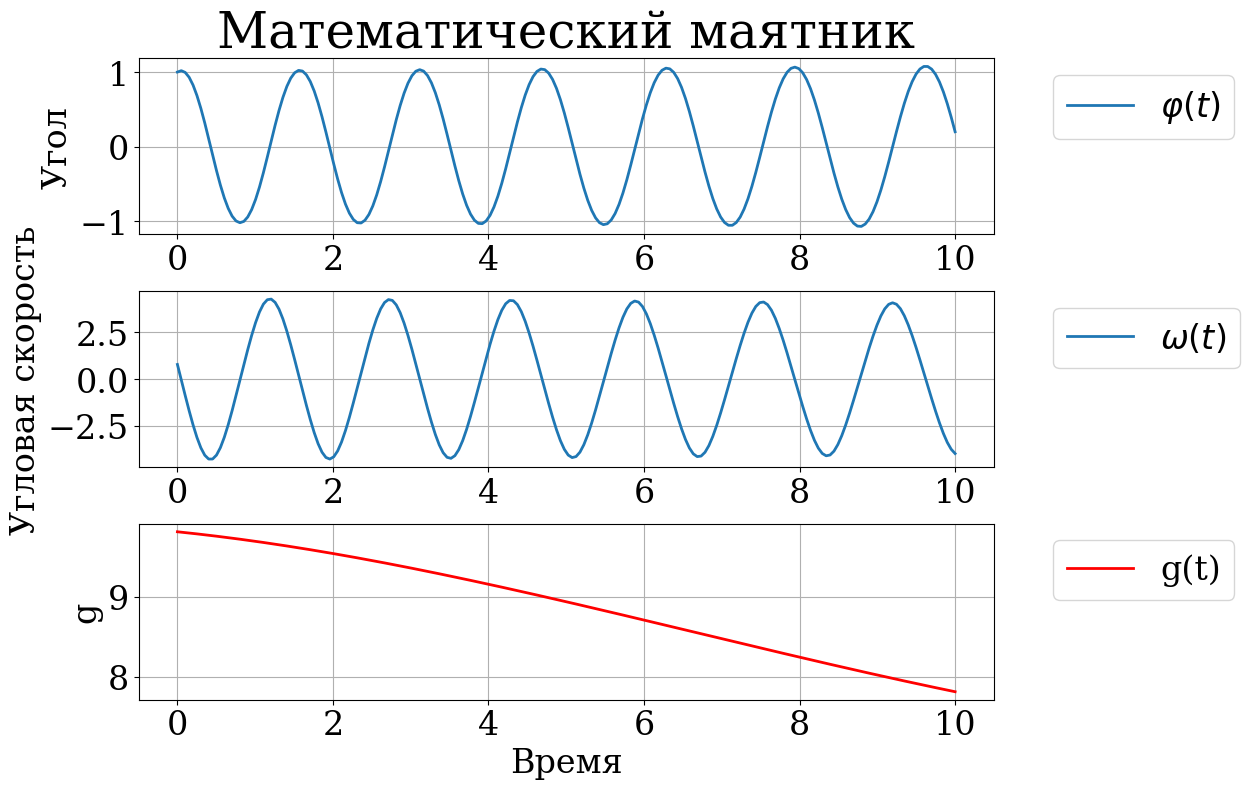

In [82]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

def solve_pendulum(g, L, initial_conditions, t_span, t_eval=None, method='RK45', rtol=1e-6):
    """
    Решает уравнение математического маятника с переменным ускорением свободного падения g(t)
    """
    def pendulum_ode(t, y):
        phi, omega = y
        current_g = g(t)
        return [
            omega,
            -(current_g / L) * np.sin(phi)
        ]

    sol = solve_ivp(
        pendulum_ode,
        t_span,
        initial_conditions,
        t_eval=t_eval,
        method=method,
        rtol=rtol
    )

    return sol

a = 0.001   # слабое кубическое изменение (чтобы избежать резких скачков)
b = -0.02   # квадратичное уменьшение (создает "горб" в середине интервала)
c = -0.1    # линейное уменьшение (общая тенденция уменьшения g)
d = 9.81    # стандартное значение g в начальный момент
g = lambda t : a * (t ** 3) + b * (t ** 2) + c * t + d
phi0 = 1
omega0 = np.pi / 4
t_span = [0, 10]
t_eval = np.linspace(*t_span, 200)
L = 0.5

sol = solve_pendulum(g, L, [phi0, omega0], t_span, t_eval)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

ax1.plot(sol.t, sol.y[0], label=r'$\varphi(t)$')
ax1.set_ylabel('Угол')
ax1.set_title('Математический маятник')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

ax2.plot(sol.t, sol.y[1], label=r'$\omega(t)$')
ax2.set_ylabel('Угловая скорость')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

ax3.plot(sol.t, g(sol.t), 'r-', label='g(t)')
ax3.set_xlabel('Время')
ax3.set_ylabel('g')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [78]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchdiffeq import odeint_adjoint as odeint
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class F(nn.Module):
    def __init__(self, L=1.0):
        super().__init__()
        self.L = L

    def forward(self, t, x):
        theta, omega, g = x[:, 0], x[:, 1], x[:, 2]
        theta_dot = omega
        omega_dot = -(g / self.L) * torch.sin(theta)
        return torch.stack([theta_dot, omega_dot], dim=1)

class GPoly(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.01))
        self.b = nn.Parameter(torch.tensor(0.1))
        self.c = nn.Parameter(torch.tensor(0.1))

    def forward(self, t):
        return 3*self.a * t**2 + 2*self.b * t + self.c

class ODEFunc(nn.Module):
    def __init__(self, f, g_prime):
        super().__init__()
        self.f = f
        self.g_prime = g_prime

    def forward(self, t, state):
        z = state[:, :2]  # theta, omega
        g = state[:, 2:]  # current g value

        t_tensor = t * torch.ones(state.size(0), 1, device=state.device)
        g_prime = self.g_prime(t_tensor)

        dz = self.f(t, torch.cat([z, g], dim=1))
        dg = g_prime

        return torch.cat([dz, dg], dim=1)

class ODELightningModule(pl.LightningModule):
    def __init__(self, ode_func, x0, t, true_z, lr=0.001):
        super().__init__()
        self.ode_func = ode_func
        self.lr = lr
        self.criterion = nn.MSELoss()
        self.register_buffer("x0", x0)
        self.register_buffer("t", t)
        self.register_buffer("true_z", true_z)

    def forward(self):
        return odeint(self.ode_func, self.x0, self.t, rtol=1e-6, atol=1e-6)

    def training_step(self, batch, batch_idx):
        pred_traj = self.forward()
        pred_z = pred_traj[:, :, :2]
        loss = self.criterion(pred_z.squeeze(), self.true_z)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",
                factor=0.8,
                patience=10,
            ),
            "monitor": "train_loss",
            "interval": "epoch",
            "frequency": 1
        }
        return [optimizer], [scheduler]

t = torch.tensor(t_eval).float().to(device)
true_z = torch.tensor(np.vstack([sol.y[0], sol.y[1]]).T).float().to(device)
z0 = torch.tensor([[phi0, omega0]]).float().to(device)
g0 = torch.tensor([[d]]).float().to(device)
x0 = torch.cat([z0, g0], dim=1).to(device)

f = F(L=L).to(device)
g_prime_poly = GPoly().to(device)
ode_func = ODEFunc(f, g_prime_poly).to(device)

model = ODELightningModule(ode_func, x0, t, true_z, lr=0.01)
dummy_loader = DataLoader(TensorDataset(torch.zeros(1)), batch_size=1)

trainer = pl.Trainer(max_epochs=300, enable_progress_bar=True, gradient_clip_val=0.5)
trainer.fit(model, dummy_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | ode_func  | ODEFunc | 3      | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [54]:
torch.save(model.forward()[:, :, 0].squeeze().detach().cpu(), 'tensor0.pt')
torch.save(model.forward()[:, :, 1].squeeze().detach().cpu(), 'tensor.pt')
torch.save(model.forward()[:, :, 2].squeeze().detach().cpu(), 'tensor0.pt')

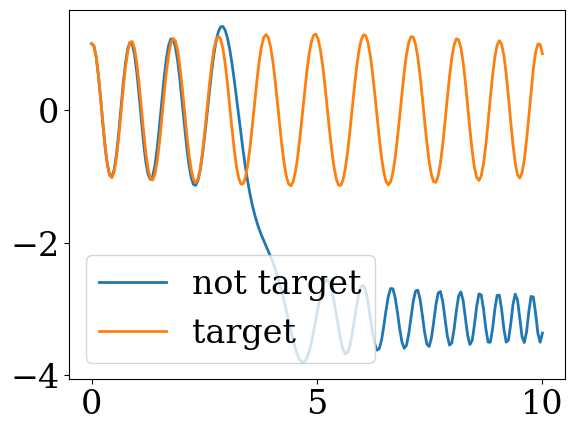

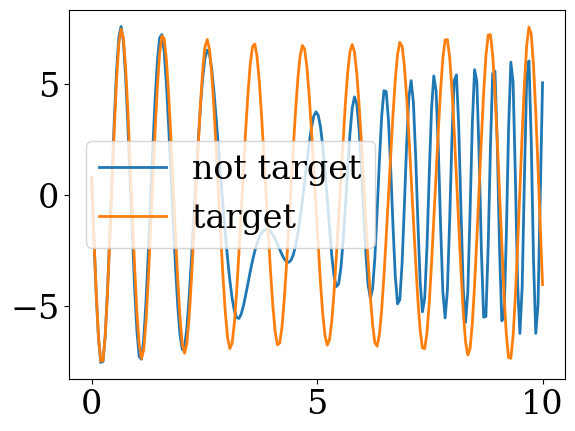

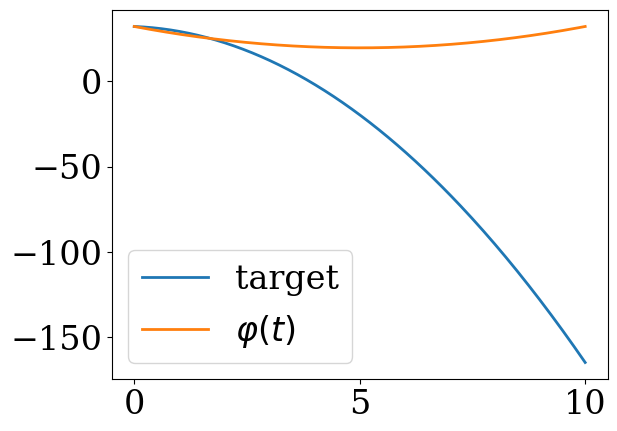

In [73]:
plt.plot(t.detach().cpu(), model.forward()[:, :, 0].squeeze().detach().cpu(), label='not target')
plt.plot(t.detach().cpu(), sol.y[0], label='target')
plt.legend()
plt.show()

plt.plot(t.detach().cpu(), model.forward()[:, :, 1].squeeze().detach().cpu(), label='not target')
plt.plot(t.detach().cpu(), sol.y[1], label='target')
plt.legend()
plt.show()

plt.plot(t.detach().cpu(), model.forward()[:, :, 2].squeeze().detach().cpu(), label='target')
plt.plot(t.detach().cpu(), g(t.detach().cpu()), label=r'$\varphi(t)$')
plt.legend()
plt.show()